In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
from tqdm.notebook import tqdm
import sys
import corner
import matplotlib.image as mpimg

sys.path.append("../")

import tdpy

from binary_planets.sim import get_hill_radius

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [17]:
def gen_arr(config, bin=True, n=12000, secondary=True):
    n_secondary = config["n_secondary"]
    l = bin*len(config["binary"].keys()) + secondary*n_secondary*len(config["secondary_0"].keys()) + 2
    arr = np.zeros((n, l))*np.nan
    keys = []
    keys.append("stable")
    keys.append("m_star")

    if secondary:
        for i in range(0, n_secondary):
            for key in config["secondary_0"].keys():
                keys.append(f"{i}/{key}")
    if bin:
        for key in config["binary"].keys():
            keys.append(f"bin/{key}")
    
    
    return arr, keys




def add_to_array(arr, config, keys, i, stable, bin=True, n=12000, secondary=True):
    if not np.any(arr):
        arr, keys = gen_arr(config, bin=bin, n=n, secondary=secondary)
        
    n_secondary = config["n_secondary"]
    arr[i, 0] = stable

    arr[i, 1] = config["m_star"]
    j = 2
    
    if secondary:
        for k in range(0, n_secondary):
            for key in config["secondary_0"].keys():
                arr[i, j] = config[f"secondary_{k}"][key]
                j += 1
    if bin:
        for key in config["binary"].keys():
            arr[i, j] = config["binary"][key]
            j += 1
    
    
    return arr, keys
    

In [18]:

run_systems = np.load("../data/compact_systems_run_composite.npy", allow_pickle=True)
names = [sys["name"] for sys in run_systems]
names = ["Kepler-150"]


dir = "no_inj"
arr_t = None
stable_t = None
stable_omega = []
unstable_omega = []
for system in tqdm(names):
    try:
        arr = None
        keys = None
        system_idx = np.where(np.array(names) == system)[0][0]


        j = 0
        stable = np.zeros(1000)

        for i in range(0, 1000):
            try:
                with open(f"../output/{dir}/{system}/{i}/config.json") as f:
                    elements = np.load(f"../output/{dir}/{system}/{i}/elements.npy")
                    a_i = elements[0, :, 0]
                    a_f = elements[-1, :, 0]
                    stable[i] = np.all(((a_i-a_f)/a_i) < 0.1)
                    cfg = json.load(f)
                    # stable[i] = cfg["secondary_0"]["omega"] < 0
                    arr, keys = add_to_array(arr, cfg, keys, j, stable[i], bin=False, secondary=True)


                print(stable[i])
                if stable[i]:
                    stable_omega.append(cfg["secondary_0"]["omega"])
                else:
                    unstable_omega.append(cfg["secondary_0"]["omega"])
                j += 1

            except Exception as e:
#                 print(e)
                pass
        arr = arr[:j, :]
        stable = stable[:j]
        stable = np.logical_not(np.logical_not(stable))
        keys = np.array(keys)
        arr[:, 1:] += np.random.random((arr.shape[0], arr.shape[1]-1)) * 1e-20


        m_tot = arr[:, keys=="bin/m1"] + arr[:, keys=="bin/m2"]
        q = arr[:, keys=="bin/m1"] / m_tot
        arr[:, keys=="bin/m1"] = m_tot
        arr[:, keys=="bin/m2"] = q
        keys[keys=="bin/m1"] = "bin/m_tot"
        keys[keys=="bin/m2"] = "bin/q"

        hill_radius = get_hill_radius(arr[:, keys=="bin/a"], 
                                      arr[:, keys=="bin/e_sys"], 
                                      arr[:, keys=="bin/m_tot"], 
                                      arr[:, keys=="m_star"])
        arr[:, keys=="bin/d"] /= hill_radius

        arr[:, keys=="bin/a"] = (np.log(arr[:, keys=="bin/a"]/run_systems[system_idx]["gap"][0]) 
                                 / np.log(run_systems[system_idx]["gap"][1]/run_systems[system_idx]["gap"][0]))

        if not np.any(arr_t):
            arr_t = arr
            stable_t = stable
        else:
            arr_t = np.vstack([arr_t, arr])
            stable_t = np.hstack([stable_t, stable])
    except Exception as e:
        print(e)

  0%|          | 0/1 [00:00<?, ?it/s]

0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0


In [24]:
idxs = np.array(["e" in key for key in keys])
# idxs = np.array([("inc" not in key) and ("/e" not in key) for key in keys])
# idxs = np.array([True for key in keys])


param_labels = np.char.replace(np.array(keys)[idxs], "_", "-")



# labels of the populations
listlablpopl = ['stable', 'not stable']

# number of populations
numbpopl = len(listlablpopl)


# number of features
numbfeat = np.sum(idxs)

# generate samples


# labels of the parameters
listlablpara = []
for k in range(numbfeat):
    listlablpara.append([param_labels[k], ''])

typepgrp = 'both'
    
listcolrpopl = ["red", "gray"]
    
tdpy.plot_grid( [arr_t[arr_t[:, 0]==1, :][: ,idxs], arr_t[arr_t[:, 0]==0,:][:,idxs]],
               listlablpara, listlablpopl=listlablpopl, typeplottdim='scat', 
               pathbase=f"../figs/corner2", listcolrpopl =listcolrpopl )
# plt.savefig("../figs/corner.pdf")


Number of samples in the populations:
not stable
26
stable
26
Writing to ../figs/corner2pmar_scat_None.png...


In [23]:
arr_t[:, 1]

array([0.90741249, 0.94452531, 0.95354265, 0.97974008, 0.93032547,
       0.92701711, 0.94568925, 0.95393882, 0.92821216, 0.93659431,
       0.91978453, 0.90570137, 0.95756787, 0.94659724, 0.92782539,
       0.94513941, 0.92337454, 0.90089877, 0.92136548, 0.92741737,
       0.97327377, 0.96730031, 0.91062969, 0.97015194, 0.90721623,
       0.95033134, 0.91714513, 0.91060982, 0.90463315, 0.97820648,
       0.90763862, 0.9585    , 0.96241035, 0.9198457 , 0.94592502,
       0.96368424, 0.93511786, 0.91169466, 0.90223835, 0.97826434,
       0.94860129, 0.93817193, 0.94519519, 0.90257603, 0.90993401,
       0.93515508, 0.93854941, 0.95455917, 0.9679628 , 0.93582471,
       0.94936232, 0.91402249])

(array([4., 2., 1., 1., 1., 2., 4., 4., 2., 5.]),
 array([0.10626491, 0.38786793, 0.66947096, 0.95107399, 1.23267701,
        1.51428004, 1.79588307, 2.07748609, 2.35908912, 2.64069214,
        2.92229517]),
 <BarContainer object of 10 artists>)

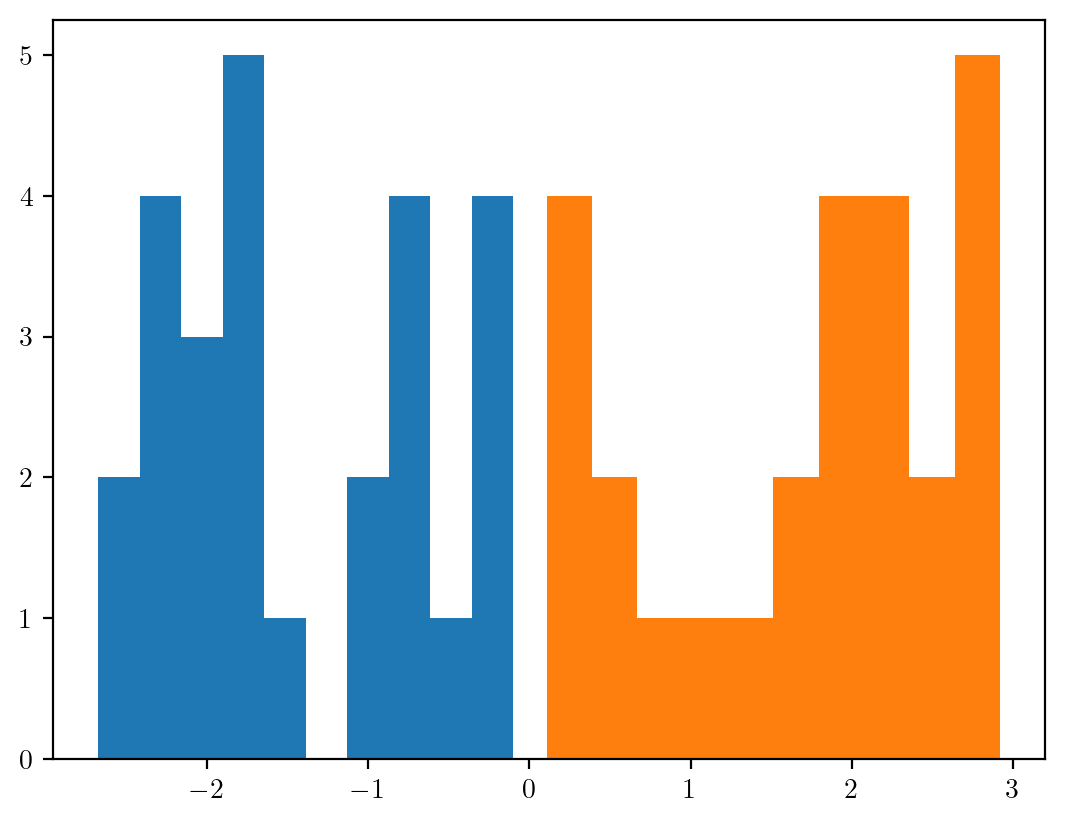

In [9]:
plt.hist(stable_omega)
plt.hist(unstable_omega)

In [2]:
cfg

NameError: name 'cfg' is not defined

In [ ]:
plt.imshow(mpimg.imread('../figs/corner_KOI-351_pmar_scat_None.png'))

In [52]:
arr[stable, :][:, idxs].shape

(14, 31)

In [22]:
idxs = np.array([("inc" not in key) and ("/e" not in key) for key in keys])



param_labels = np.char.replace(np.array(keys)[idxs], "_", "-")



# labels of the populations
listlablpopl = ['stable', 'not stable']

# number of populations
numbpopl = len(listlablpopl)


# number of features
numbfeat = np.sum(idxs)

# generate samples


# labels of the parameters
listlablpara = []
for k in range(numbfeat):
    listlablpara.append([param_labels[k], ''])

typepgrp = 'both'
    
j 
tdpy.plot_grid( [arr[stable, :][: ,idxs][:, :j], arr[np.logical_not(stable),:][:,idxs][:, :j]], listlablpara[:j], listlablpopl=listlablpopl, typeplottdim='scat', pathbase="../figs/corner")
# plt.savefig("../figs/corner.pdf")
# plt.show()

Number of samples in the populations:
not stable
169
stable
831
Writing to ../figs/cornerpmar_scat_None.png...


In [26]:
id(cfg)

139879228196352

In [35]:
c = dict(cfg)
id(c)

139879441600256

In [38]:
c["name"]

'bin_inj/Kepler-102/999'

In [37]:
cfg["name"] = "test"